## Submit job

In [1]:
from quri_parts_oqtopus.backend import OqtopusSseBackend
from pathlib import Path
device = "anemone"
program = "chvron_pattern"
backend = OqtopusSseBackend()

job = backend.run_sse(
    file_path=f"program/{device}/{program}.py",
    device_id=f"{device}-pulse",
    name=program,
)
print(f"job_id = {job.job_id}")
job.wait_for_completion()
print(f"job_status = {job.status}")
print(f"elapsed_time={job.execution_time}")

job_id = 068e7386-9ad1-77e3-8000-f21986f1adac
job_status = succeeded
elapsed_time=546.572


## Download job result

In [2]:
Path("download").mkdir(exist_ok=True)
backend.download_log(
    job_id=job.job_id,
    save_dir="download",
)


'download/sselog_068e7386-9ad1-77e3-8000-f21986f1adac.zip'

## Extract zip file

In [3]:
import zipfile
zip_path = Path(f"download/sselog_{job.job_id}.zip")
extract_dir = Path("extracted")

with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall(extract_dir)
log_path = extract_dir / "ssecontainer.log"
new_log_path = extract_dir / f"sselog_{job.job_id}.log"

# rename
if log_path.exists():
    log_path.rename(new_log_path)

print("extracted file:", list(extract_dir.rglob("*")))

with new_log_path.open(encoding="utf-8") as f:
    for i, line in enumerate(f, start=1):
        print(f"{i}: {line.strip()}")

extracted file: [PosixPath('extracted/sselog_068e7386-9ad1-77e3-8000-f21986f1adac.log'), PosixPath('extracted/sselog_068db9ea-2552-747a-8000-ee7fd92dad73.log'), PosixPath('extracted/sselog_068d43a1-8db5-7ed2-8000-a70b43690f76.log'), PosixPath('extracted/sselog_068d44cf-8a69-7bbd-8000-e62ed35217cd.log'), PosixPath('extracted/sselog_068d448d-9e95-713f-8000-205d35190713.log'), PosixPath('extracted/sselog_068d4398-51f5-79c9-8000-eca7e8f7b08e.log'), PosixPath('extracted/ssecontainer_068d438e-ab45-7d8b-8000-49abd316f766.log'), PosixPath('extracted/sselog_068e7365-d297-7c74-8000-83f02325276a.log'), PosixPath('extracted/sselog_068e72ce-1d00-73a6-8000-2b68afc602d8.log'), PosixPath('extracted/sselog_068d4466-1937-7e0c-8000-82f3289c43c7.log'), PosixPath('extracted/sselog_068d43c0-bf35-7017-8000-2912b8176b35.log'), PosixPath('extracted/sselog_068e737d-4ffe-7525-8000-7af6482398dd.log'), PosixPath('extracted/sselog_068e7387-af08-715d-8000-845267840d41.log'), PosixPath('extracted/sselog_068d43e5-89ff

## Extract payload

In [4]:
from pathlib import Path
import ast

payloads = []
with new_log_path.open(encoding="utf-8") as f:
    for line in f:
        if "payload=" in line:
            rhs = line.split("payload=", 1)[1].strip()
            try:
                data = ast.literal_eval(rhs)
                payloads.append(data)
            except Exception as e:
                print("parse error:", e)

print(payloads)


[{'time_range': [0.0, 8.0, 16.0, 24.0, 32.0, 40.0, 48.0, 56.0, 64.0, 72.0, 80.0, 88.0, 96.0, 104.0, 112.0, 120.0, 128.0, 136.0, 144.0, 152.0, 160.0, 168.0, 176.0, 184.0, 192.0, 200.0, 208.0, 216.0, 224.0, 232.0, 240.0, 248.0, 256.0, 264.0, 272.0, 280.0, 288.0, 296.0, 304.0, 312.0, 320.0, 328.0, 336.0, 344.0, 352.0, 360.0, 368.0, 376.0, 384.0, 392.0, 400.0], 'detuning_range': [-0.05, -0.048, -0.046, -0.044, -0.042, -0.04, -0.038, -0.036, -0.034, -0.032, -0.03, -0.028, -0.026, -0.024, -0.022, -0.02, -0.018, -0.016, -0.014, -0.012, -0.01, -0.008, -0.006, -0.004, -0.002, 0.0, 0.002, 0.004, 0.006, 0.008, 0.01, 0.012, 0.014, 0.016, 0.018, 0.02, 0.022, 0.024, 0.026, 0.028, 0.03, 0.032, 0.034, 0.036, 0.038, 0.04, 0.042, 0.044, 0.046, 0.048, 0.05], 'frequencies': {'Q08': 8.195345886548736}, 'chevron_data': {'Q08': [[0.9933750033378601, 1.0335619449615479, 0.9781150221824646, 1.0688689947128296, 0.9404839873313904, 0.9572579860687256, 1.0149149894714355, 0.9481909871101379, 0.9444649815559387, 0

## Plot IQ data

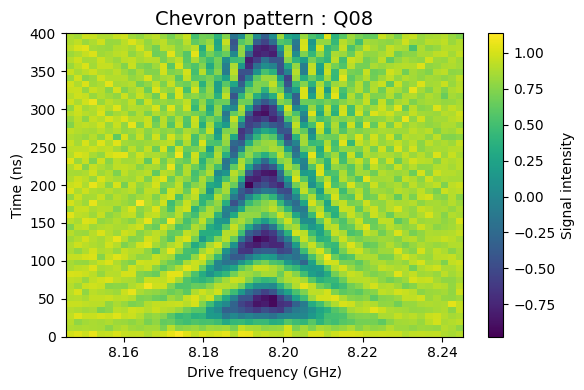

In [7]:
import numpy as np
import matplotlib.pyplot as plt

p = payloads[0]

detuning_range = np.array(p["detuning_range"])
frequencies = p["frequencies"]
time_range = np.array(p["time_range"])
chevron_data = p["chevron_data"]
label=list(p["chevron_data"].keys())[0]


fig, ax = plt.subplots(figsize=(6, 4))
im = ax.imshow(
    chevron_data[label],
    aspect="auto",
    origin="lower",
    extent=[
        detuning_range[0] + frequencies[label],
        detuning_range[-1] + frequencies[label],
        time_range[0],
        time_range[-1],
    ],
    cmap="viridis",
)

ax.set_title(f"Chevron pattern : {label}", fontsize=14)
ax.set_xlabel("Drive frequency (GHz)")
ax.set_ylabel("Time (ns)")


cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Signal intensity")

plt.tight_layout()
plt.show()
